# Task 2.3: Document analysis and recognition

### Imporing Libraries and Dependencies

In [1]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt
import statistics
import math, time

## 1. Hough transform for document skew estimation

### Step 1. Load image from file and binarise the image using a threshold = 200

In [2]:
def load_doc(image_name):
    doc = cv.imread(image_name, 0)
    return doc

In [3]:
def get_binary_image(doc):
    threshold = 200
    ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
    return doc_bin

### Step 2. Get negative version of the binarised image by subtracting the binarised image from 255

In [4]:
def get_negative_image(doc_bin_img):
    # convert black/white to white/black
    doc_bin_neg = 255 - doc_bin_img
    return doc_bin_neg

### Step 3. Extract connected components from the negative image

In [5]:
def extract_connected_components(doc_bin_neg):
    num_labels, labels_im = cv.connectedComponents(doc_bin_neg)
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i, j] >= 0:
                connected_components[labels_im[i, j]].append((j, i))
    return connected_components

### Strategy A requires sending all the pixels, so no candidate selection selection

### Strategy B - Selecting the centers of candidate points as connected components

In [6]:
def get_mean_candidate(conn_comp):
    candidate_coords = []
    for coordinate_list in conn_comp:
        sum_x = 0
        sum_y = 0
        coordinate_len = len(coordinate_list)
        center_coords = []
        for x, y in coordinate_list:
            sum_x += x
            sum_y += y
        center_coords = [round(sum_x / coordinate_len), round(sum_y / coordinate_len)] 
        candidate_coords.append(center_coords)
    return candidate_coords           

### Strategy C - Selecting the point which has maximum y-coordinate in each connected component

In [7]:
def get_max_y_coordinate(connected_components):
    candidate_coords = []
    for component in connected_components:
        result = max(component, key = lambda i : i[0])
        candidate_coords.append([result[0], result[1]])
    return candidate_coords

### Step 5. Remove all pixels which are not candidate points from the negative image.

In [8]:
def remove_non_candidates(neg_bin_image, candidate_points):
    height, width = neg_bin_image.shape
    empty_image = np.zeros((height, width), np.uint8)
    for item in candidate_points:
        x = item[0]
        y = item[1]
        empty_image[y][x] = 255
    return empty_image   

### Step 6. Define parameters for Hough space.

In [9]:
distance_resolution = 1
angular_resolution = np.pi/180

### Step 7. Apply Hough transform on the negative image

In [10]:
def apply_hough_transform(document_image, density_threshold = 10):
    print("density_threshold ", density_threshold)
    lines = cv.HoughLines(np.array(document_image), distance_resolution, angular_resolution, density_threshold)
    angles = []
    for line in lines:
        distance, angle = line[0]
        angles.append(angle)
    return angles

### Step 8. Create an array to store the angles of all lines detected by Hough transform.

In [11]:
angles_of_all_lines = []

### Step 9. Apply statistics.median to the array of angles created in the previous step

In [12]:
def get_median(detected_angles):
    return statistics.median(detected_angles)

### Deskew Image

In [13]:
def deskew_image(median_angle, document_image):
    #rotate image
    height, width = document_image.shape
    c_x = (width - 1) / 2.0
    c_y = (height - 1) / 2.0
    c = (c_x, c_y)

    M = cv.getRotationMatrix2D(c, median_angle * 180 / math.pi - 90, 1)
    doc_deskewed = cv.warpAffine(document_image, M, (width, height))
    return doc_deskewed

### Load Image, Get Binary Image, and Get Negative Image

In [14]:
doc = load_doc("doc.jpg")
doc_bin = get_binary_image(doc)
doc_bin_neg = get_negative_image(doc_bin)

### Strategy - A Implementation

In [15]:
def execute_strategy_A(doc_img, neg_img, file_name, density_threshold):
    print(file_name + "_a_image.png")
    cv.imwrite(file_name + "_a_image.png", neg_img)
    angles_of_all_lines = apply_hough_transform(neg_img, density_threshold)
    median_angle = get_median(angles_of_all_lines)
    doc_deskewed = deskew_image(median_angle, doc_img)
    return doc_deskewed

### Strategy - B Implementation

In [16]:
def execute_strategy_B(doc_img, neg_img, file_name, density_threshold):
    connected_components = extract_connected_components(neg_img)
    mean_based_candidate_points = get_mean_candidate(connected_components)
    image_B = remove_non_candidates(neg_img, mean_based_candidate_points)
    print(file_name + "_b_image.png")
    cv.imwrite(file_name + "_b_image.png", image_B)
    
    angles_of_all_lines = apply_hough_transform(image_B, density_threshold)
    median_angle = get_median(angles_of_all_lines)
    doc_deskewed = deskew_image(median_angle, doc_img)
    return doc_deskewed   

### Strategy - C Implementation

In [17]:
def execute_strategy_C(doc_img, neg_img, file_name, density_threshold):
    connected_components = extract_connected_components(neg_img)
    max_y_coords = get_max_y_coordinate(connected_components)
    image_C = remove_non_candidates(neg_img, max_y_coords)
    print(file_name + "_c_image.png")
    cv.imwrite(file_name + "_c_image.png", image_C)
    
    angles_of_all_lines = apply_hough_transform(image_C, density_threshold)
    median_angle = get_median(angles_of_all_lines)
    doc_deskewed = deskew_image(median_angle, doc_img)

    return doc_deskewed

## Testing above Strategies with doc.jpg

### Strategy A with doc.jpg - Setting density_threshold = 10

In [18]:
density_threshold = 10

doc_a_image.png
density_threshold  10
Time for execution of strategy 0.09035706520080566


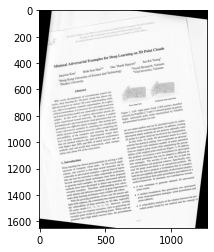

In [19]:
start_time = time.time()
doc_deskewed_A = execute_strategy_A(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy", time.time() - start_time)
cv.imwrite("doc_deskewed_a_10.png", doc_deskewed_A)
plt.imshow(doc_deskewed_A, 'gray')

## 2. Performance analysis

## 2.1. Candidate point selection

### Strategy B with doc.jpg - Setting density_threshold = 10

doc_b_image.png
density_threshold  10
Time for execution of strategy 1.9343900680541992


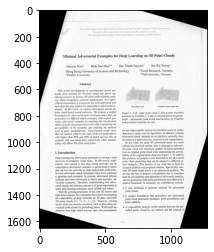

In [20]:
start_time = time.time()
doc_deskewed_B = execute_strategy_B(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy", time.time() - start_time)

cv.imwrite("doc_deskewed_b_10.png", doc_deskewed_B)
plt.imshow(doc_deskewed_B, 'gray')

### Strategy C with doc.jpg - Setting density_threshold = 10

doc_c_image.png
density_threshold  10
Time for execution of strategy.png 1.8930208683013916


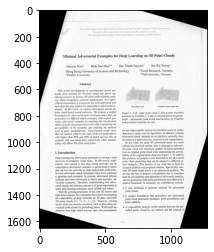

In [21]:
start_time = time.time()
doc_deskewed_C = execute_strategy_C(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)

cv.imwrite("doc_deskewed_c_10.png", doc_deskewed_C)
plt.imshow(doc_deskewed_C, 'gray')

## 2.2. Parameter setting - 

### Experimenting with density_threshold = 100, strategy A on doc.jpg

doc_a_image.png
density_threshold  100
Time for execution of strategy.png 0.07730507850646973


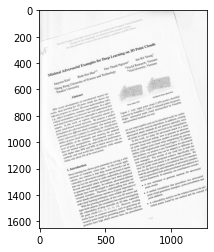

In [124]:
density_threshold = 100
start_time = time.time()
doc_deskewed_A_100 = execute_strategy_A(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_a_100.png", doc_deskewed_A_100)
plt.imshow(doc_deskewed_A_100, 'gray')

### Experimenting with density_threshold = 200, strategy A on doc.jpg

doc_a_image.png
density_threshold  200
Time for execution of strategy.png 0.06737399101257324


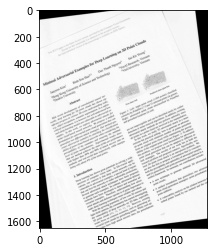

In [23]:
density_threshold = 200
start_time = time.time()
doc_deskewed_A_200 = execute_strategy_A(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_a_200.png", doc_deskewed_A_200)
plt.imshow(doc_deskewed_A_200, 'gray')

### Experimenting with density_threshold = 235, strategy A on doc.jpg

doc_a_image.png
density_threshold  235
Time for execution of strategy.png 0.06601595878601074


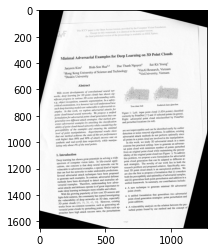

In [24]:
density_threshold = 235
start_time = time.time()
doc_deskewed_A_235 = execute_strategy_A(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_a_235.png", doc_deskewed_A_235)
plt.imshow(doc_deskewed_A_235, 'gray')

### Experimenting with density_threshold = 5, strategy B on doc.jpg

doc_b_image.png
density_threshold  5
Time for execution of strategy.png 2.021045207977295


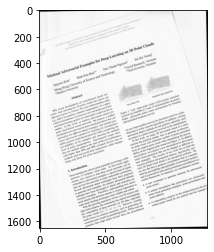

In [125]:
density_threshold = 5
start_time = time.time()
doc_deskewed_B_5 = execute_strategy_B(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_b_5.png", doc_deskewed_B_5)
plt.imshow(doc_deskewed_B_5, 'gray')

### Experimenting with density_threshold = 20, strategy B on doc.jpg

doc_b_image.png
density_threshold  20
Time for execution of strategy.png 1.908336877822876


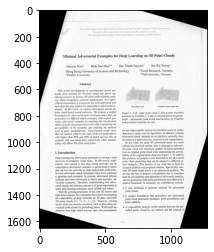

In [26]:
density_threshold = 20
start_time = time.time()
doc_deskewed_B_20 = execute_strategy_B(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_b_20.png", doc_deskewed_B_20)
plt.imshow(doc_deskewed_B_20, 'gray')

### Experimenting with density_threshold = 30, strategy B on doc.jpg

doc_b_image.png
density_threshold  30
Time for execution of strategy.png 1.8967862129211426


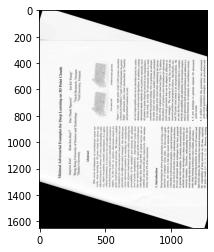

In [27]:
density_threshold = 30
start_time = time.time()
doc_deskewed_B_30 = execute_strategy_B(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_b_30.png", doc_deskewed_B_30)
plt.imshow(doc_deskewed_B_30, 'gray')

### Experimenting with density_threshold = 5, strategy C on doc.jpg

doc_c_image.png
density_threshold  5
Time for execution of strategy.png 1.9049949645996094


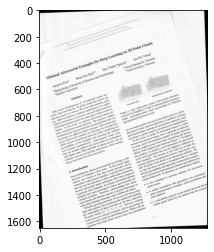

In [28]:
density_threshold = 5
start_time = time.time()
doc_deskewed_C_5 = execute_strategy_C(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_c_5.png", doc_deskewed_C_5)
plt.imshow(doc_deskewed_C_5, 'gray')

### Experimenting with density_threshold = 15, strategy C on doc.jpg

doc_c_image.png
density_threshold  15
Time for execution of strategy.png 1.924333095550537


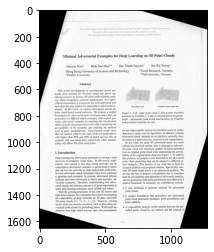

In [29]:
density_threshold = 15
start_time = time.time()
doc_deskewed_C_15 = execute_strategy_C(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_c_15.png", doc_deskewed_C_15)
plt.imshow(doc_deskewed_C_15, 'gray')

### Experimenting with density_threshold = 20, strategy C on doc.jpg

doc_c_image.png
density_threshold  20
Time for execution of strategy.png 1.899878978729248


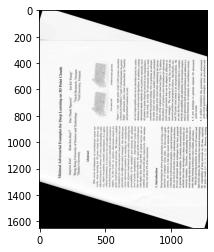

In [30]:
density_threshold = 20
start_time = time.time()
doc_deskewed_C_20 = execute_strategy_C(doc, doc_bin_neg, "doc", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_deskewed_c_20.png", doc_deskewed_C_20)
plt.imshow(doc_deskewed_C_20, 'gray')

## 3. Other test cases

## doc_1.jpg 

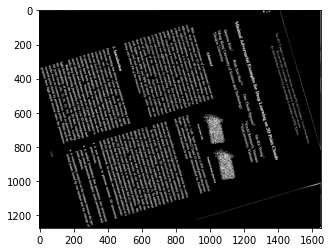

In [31]:
doc_1 = load_doc("doc_1.jpg")
doc_1_bin = get_binary_image(doc_1)
doc_1_bin_neg = get_negative_image(doc_1_bin)
plt.imshow(doc_1_bin_neg, 'gray')

#### Strategy A

doc_1_a_image.png
density_threshold  300
Time for execution of strategy.png 0.06539702415466309


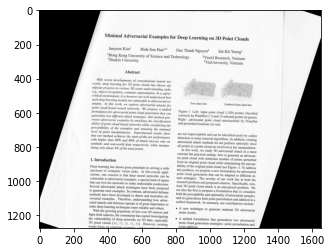

In [32]:
density_threshold = 300
start_time = time.time()
doc_1_deskewed_A_300 = execute_strategy_A(doc_1, doc_1_bin_neg, "doc_1", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_1_deskewed_a_300.png", doc_1_deskewed_A_300)
plt.imshow(doc_1_deskewed_A_300, 'gray')

#### Strategy B

doc_1_b_image.png
density_threshold  15
Time for execution of strategy.png 1.9443910121917725


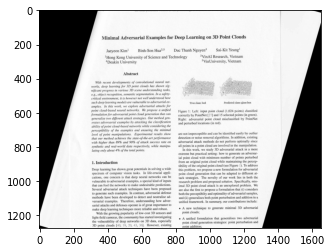

In [33]:
density_threshold = 15
start_time = time.time()
doc_1_deskewed_B_15 = execute_strategy_B(doc_1, doc_1_bin_neg, "doc_1", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_1_deskewed_b_15.png", doc_1_deskewed_B_15)
plt.imshow(doc_1_deskewed_B_15, 'gray')

#### Strategy C

doc_1_c_image.png
density_threshold  15
Time for execution of strategy.png 1.8922841548919678


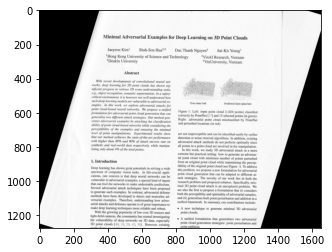

In [34]:
density_threshold = 15
start_time = time.time()
doc_1_deskewed_C_15 = execute_strategy_C(doc_1, doc_1_bin_neg, "doc_1", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_1_deskewed_c_15.png", doc_1_deskewed_C_15)
plt.imshow(doc_1_deskewed_C_15, 'gray')

## doc_2.jpg

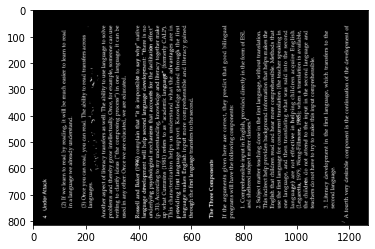

In [35]:
doc_2 = load_doc("doc_2.jpg")
doc_2_bin = get_binary_image(doc_2)
doc_2_bin_neg = get_negative_image(doc_2_bin)
plt.imshow(doc_2_bin_neg, 'gray')

#### Strategy A

doc_2_a_image.png
density_threshold  300
Time for execution of strategy.png 0.038340091705322266


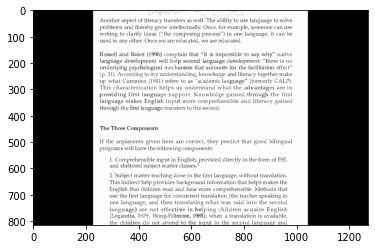

In [122]:
density_threshold = 300
start_time = time.time()
doc_2_deskewed_A_300 = execute_strategy_A(doc_2, doc_2_bin_neg, "doc_2", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_2_deskewed_A_300.png", doc_2_deskewed_A_300)
plt.imshow(doc_2_deskewed_A_300, 'gray')

#### Strategy B

doc_2_b_image.png
density_threshold  20
Time for execution of strategy.png 1.0071980953216553


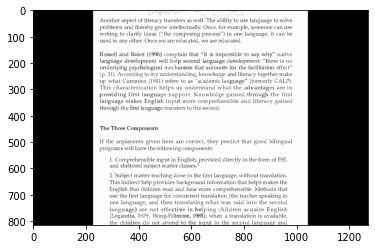

In [121]:
density_threshold = 20
start_time = time.time()
doc_2_deskewed_B_20 = execute_strategy_B(doc_2, doc_2_bin_neg, "doc_2", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_2_deskewed_b_20.png", doc_2_deskewed_B_20)
plt.imshow(doc_2_deskewed_B_20, 'gray')

#### Strategy C

doc_2_c_image.png
density_threshold  20
Time for execution of strategy.png 1.1299550533294678


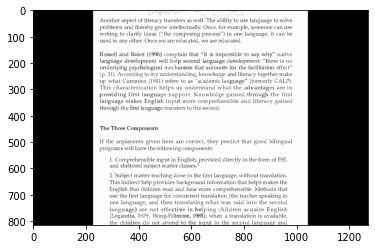

In [123]:
density_threshold = 20
start_time = time.time()
doc_2_deskewed_C_20 = execute_strategy_C(doc_2, doc_2_bin_neg, "doc_2", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_2_deskewed_c_20.png", doc_2_deskewed_C_20)
plt.imshow(doc_2_deskewed_C_20, 'gray')

## doc_3.jpg

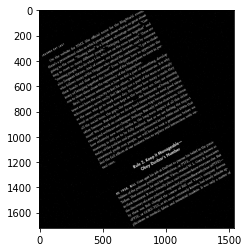

In [39]:
doc_3 = load_doc("doc_3.jpg")
doc_3_bin = get_binary_image(doc_3)
doc_3_bin_neg = get_negative_image(doc_3_bin)
plt.imshow(doc_3_bin_neg, 'gray')

#### strategy A

doc_3_a_image.png
density_threshold  300
Time for execution of strategy.png 0.06276202201843262


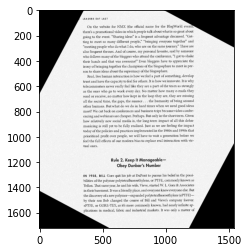

In [40]:
density_threshold = 300
start_time = time.time()
doc_3_deskewed_A_300 = execute_strategy_A(doc_3, doc_3_bin_neg, "doc_3", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_3_deskewed_a_300.png", doc_3_deskewed_A_300)
plt.imshow(doc_3_deskewed_A_300, 'gray')

#### strategy B

doc_3_b_image.png
density_threshold  20
Time for execution of strategy.png 2.400937080383301


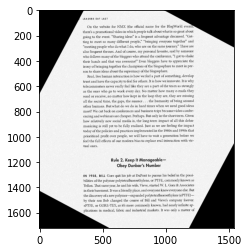

In [42]:
density_threshold = 20
start_time = time.time()
doc_3_deskewed_B_20 = execute_strategy_B(doc_3, doc_3_bin_neg, "doc_3", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_3_deskewed_b_20.png", doc_3_deskewed_B_20)
plt.imshow(doc_3_deskewed_B_20, 'gray')

#### strategy C

doc_3_c_image.png
density_threshold  20
Time for execution of strategy.png 2.382591962814331


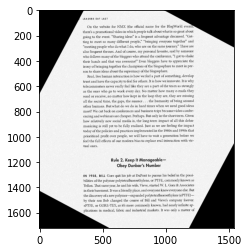

In [43]:
density_threshold = 20
start_time = time.time()
doc_3_deskewed_C_20 = execute_strategy_C(doc_3, doc_3_bin_neg, "doc_3", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_3_deskewed_c_20.png", doc_3_deskewed_C_20)
plt.imshow(doc_3_deskewed_C_20, 'gray')

## doc_4.jpg

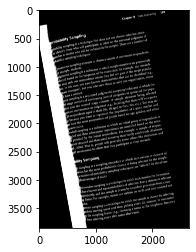

In [56]:
doc_4 = load_doc("doc_4.jpg")
doc_4_bin = get_binary_image(doc_4)
doc_4_bin_neg = get_negative_image(doc_4_bin)
plt.imshow(doc_4_bin_neg, 'gray')

#### strategy A

doc_4_a_image.png
density_threshold  5
Time for execution of strategy.png 1.1805391311645508


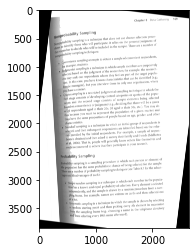

In [78]:
density_threshold = 5
start_time = time.time()
doc_4_deskewed_A_5 = execute_strategy_A(doc_4, doc_4_bin, "doc_4", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_4_deskewed_a_5.png", doc_4_deskewed_A_5)
plt.imshow(doc_4_deskewed_A_5, 'gray')

#### strategy B

doc_4_b_image.png
density_threshold  2
Time for execution of strategy.png 9.287030696868896


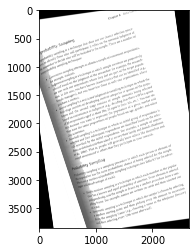

In [79]:
density_threshold = 2
start_time = time.time()
doc_4_deskewed_B_2 = execute_strategy_B(doc_4, doc_4_bin, "doc_4", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_4_deskewed_B_2.png", doc_4_deskewed_B_2)
plt.imshow(doc_4_deskewed_B_2, 'gray')

#### strategy c

doc_4_c_image.png
density_threshold  3
Time for execution of strategy.png 9.316358089447021


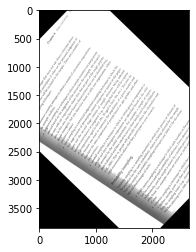

In [80]:
density_threshold = 3
start_time = time.time()
doc_4_deskewed_C_3 = execute_strategy_C(doc_4, doc_4_bin, "doc_4", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_4_deskewed_C_3.png", doc_4_deskewed_C_3)
plt.imshow(doc_4_deskewed_C_3, 'gray')

## doc_5.jpg

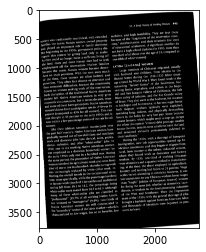

In [81]:
doc_5 = load_doc("doc_5.jpg")
doc_5_bin = get_binary_image(doc_5)
doc_5_bin_neg = get_negative_image(doc_5_bin)
plt.imshow(doc_5_bin_neg, 'gray')

#### strategy A

doc_5_a_image.png
density_threshold  500
Time for execution of strategy.png 0.30893731117248535


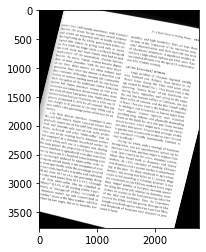

In [130]:
density_threshold = 500
start_time = time.time()
doc_5_deskewed_A_500 = execute_strategy_A(doc_5, doc_5_bin_neg, "doc_5", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_5_deskewed_a_500.png", doc_5_deskewed_A_500)
plt.imshow(doc_5_deskewed_A_500, 'gray')

#### strategy B

doc_5_b_image.png
density_threshold  20
Time for execution of strategy.png 9.65585994720459


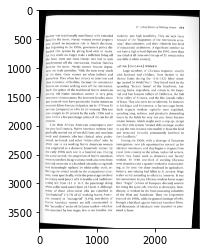

In [83]:
density_threshold = 20
start_time = time.time()
doc_5_deskewed_B_20 = execute_strategy_B(doc_5, doc_5_bin_neg, "doc_5", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_5_deskewed_b_20.png", doc_5_deskewed_B_20)
plt.imshow(doc_5_deskewed_B_20, 'gray')

#### strategy C

doc_5_b_image.png
density_threshold  15
Time for execution of strategy.png 9.591933965682983


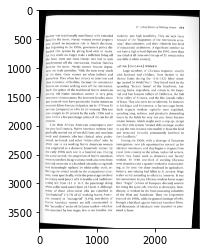

In [84]:
density_threshold = 15
start_time = time.time()
doc_5_deskewed_C_15 = execute_strategy_B(doc_5, doc_5_bin_neg, "doc_5", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_5_deskewed_c_15.png", doc_5_deskewed_C_15)
plt.imshow(doc_5_deskewed_C_15, 'gray')

## doc_6.jpg

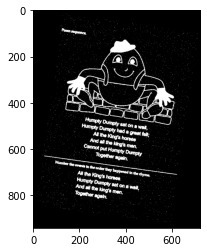

In [126]:
doc_6 = load_doc("doc_6.jpg")
doc_6_bin = get_binary_image(doc_6)
doc_6_bin_neg = get_negative_image(doc_6_bin)
plt.imshow(doc_6_bin_neg, 'gray')

### strategy A

doc_6_a_image.png
density_threshold  400
Time for execution of strategy.png 0.029913902282714844


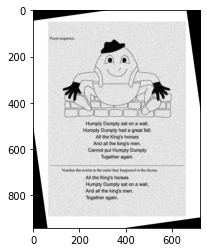

In [129]:
density_threshold = 400
start_time = time.time()
doc_6_deskewed_A_400 = execute_strategy_A(doc_6, doc_6_bin_neg, "doc_6", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_6_deskewed_a_400.png", doc_6_deskewed_A_400)
plt.imshow(doc_6_deskewed_A_400, 'gray')

### strategy B

doc_6_b_image.png
density_threshold  3
Time for execution of strategy.png 0.6489238739013672


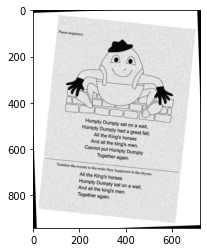

In [138]:
density_threshold = 3
start_time = time.time()
doc_6_deskewed_B_3 = execute_strategy_B(doc_6, doc_6_bin_neg, "doc_6", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_5_deskewed_b_3.png", doc_6_deskewed_B_3)
plt.imshow(doc_6_deskewed_B_3, 'gray')

### strategy C

doc_6_c_image.png
density_threshold  1
Time for execution of strategy.png 0.7699699401855469


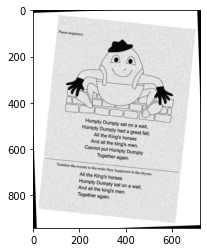

In [142]:
density_threshold = 1
start_time = time.time()
doc_6_deskewed_C_1 = execute_strategy_C(doc_6, doc_6_bin_neg, "doc_6", density_threshold)
print("Time for execution of strategy.png", time.time() - start_time)
cv.imwrite("doc_5_deskewed_c_1.png", doc_6_deskewed_C_1)
plt.imshow(doc_6_deskewed_C_1, 'gray')

## 4. Text recognition using pytesseract

In [85]:
!pip install pytesseract

In [86]:
import pytesseract

In [99]:
def extract_text_from_image(image, file_name):
    text_extracted = pytesseract.image_to_string(image)
    print(text_extracted)
    pdf = pytesseract.image_to_pdf_or_hocr(image, extension="pdf")
    with open(file_name, 'w+b') as f:
        f.write(pdf)

## Question 4 : Section 1

### Extracting text and print the message from doc.jpg

In [101]:
extract_text_from_image(doc, "doc_ori.pdf")

yacye™ es
sions got
ape Senne

eel gentiti




In [102]:
extract_text_from_image(doc_deskewed_B, "doc_deskewed_B.pdf")

Jaeyeon Kim! Binh-Son Hua**
Hong Kong Unive
‘Deakin University

Abstract

With recent developments of convolutional neural net-
works, deep learning for 3D point clouds has shown
nificant progress in various 3D scene understanding tasks,
object recognition, s fety-
critical environment, it is however not well understood how
such deep learning models are vulnerable to adversarial ex-
amples. In this work, we explore adversarial attacks for
point cloud-based neural networks. We propose a unified
formulation for adversarial point cloud generation that can
generalise two different attack strategies. Our method gen-
erates adversarial examples by attacking the classification
ability of point cloud-based networks while considering the
perceptibility of the examples and ensuring the minimal
level of point manipulations. Experimental results show
that our method achieves the state-of-the-art performance
with higher than 89% and 90% of attack s rate on
synthetic and real-world data respectively

## Question 4 : Section 2

## Document Recognition System

In [119]:
def recognize_document(file_name, selection_strategy, density_threshold):
    deskewed = None
    doc = load_doc(file_name)
    doc_bin = get_binary_image(doc)
    doc_bin_neg = get_negative_image(doc_bin)
    img_name = file_name.split(".")[0]
    
    if selection_strategy == "a":
        deskewed = execute_strategy_A(doc, doc_bin_neg, img_name, density_threshold)
    elif selection_strategy == "b":
        deskewed = execute_strategy_B(doc, doc_bin_neg, img_name, density_threshold)
    elif selection_strategy == "c":
        deskewed = execute_strategy_C(doc, doc_bin_neg, img_name, density_threshold)
    else:
        deskewed = doc
        selection_strategy = "_"
        density_threshold = 0
    
    threshold_num = str(density_threshold)
    pdf = pytesseract.image_to_pdf_or_hocr(deskewed, extension='pdf')
    pdf_name = f"{img_name}_deskewed_{selection_strategy}_{threshold_num}.pdf"
    
    
    with open(pdf_name, 'w+b') as f:
        f. write(pdf)
        print(f"{pdf_name} created successfully")

In [152]:
recognize_document('doc.jpg', "none", 0)

doc_deskewed___0.pdf created successfully


In [143]:
recognize_document('doc.jpg', 'b', 10)

doc_b_image.png
density_threshold  10
doc_deskewed_b_10.pdf created successfully


In [144]:
recognize_document('doc_1.jpg', 'b', 15)

doc_1_b_image.png
density_threshold  15
doc_1_deskewed_b_15.pdf created successfully


In [145]:
recognize_document('doc_2.jpg', 'b', 20)

doc_2_b_image.png
density_threshold  20
doc_2_deskewed_b_20.pdf created successfully


In [146]:
recognize_document('doc_3.jpg', 'b', 20)

doc_3_b_image.png
density_threshold  20
doc_3_deskewed_b_20.pdf created successfully


In [149]:
recognize_document('doc_4.jpg', 'a', 5)

doc_4_a_image.png
density_threshold  5
doc_4_deskewed_a_5.pdf created successfully


In [148]:
recognize_document('doc_5.jpg', 'b', 20)

doc_5_b_image.png
density_threshold  20
doc_5_deskewed_b_20.pdf created successfully


In [150]:
recognize_document('doc_6.jpg', 'a', 400)

doc_6_a_image.png
density_threshold  400
doc_6_deskewed_a_400.pdf created successfully
